# Imports

In [1]:
# install PyArabic library for Arabic preprocessing
!pip install PyArabic

In [2]:
# install tensorflow_addons for AdamW optimizer
# !pip install tensorflow_addons

In [3]:
! pip install gdown

  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - \ | / - done
    Preparing wheel metadata ... - \ | / - done
  Created wheel for gdown: filename=gdown-4.5.1-py3-none-any.whl size=14933 sha256=02fbf378f6470b8f1f32c8a67fd0407db0ad58df472181c70d35581089f2c637
  Stored in directory: /root/.cache/pip/wheels/3d/ec/b0/a96d1d126183f98570a785e6bf8789fca559853a9260e928e1
Successfully built gdown


In [4]:
# Standard libraries imports
import io
import gc
import re
import ast
import math
import gdown
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from lxml import etree
import pyarabic.araby as araby

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

2022-07-01 19:46:36.073326: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-07-01 19:46:36.073453: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Hardware Detection

In [5]:
# Detect hardware
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select an appropriate distribution strategy
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

2022-07-01 19:46:41.906551: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-01 19:46:41.909866: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-07-01 19:46:41.909900: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-01 19:46:41.909952: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (74e559256dc0): /proc/driver/nvidia/version does not exist
2022-07-01 19:46:41.912800: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Running on TPU  ['10.0.0.2:8470']
Number of accelerators:  8


# Configs

In [6]:
# configurations class
class config:

    MAXLEN = 18 # maximum length of sequence

    # model configs
    BATCH_SIZE_PER_REPLICA = 256 # batch size per replica
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync # global batch size
    EPOCHS = 100 # number of epochs
    LEARNING_RATE = 5E-5 # learning rate
    BUFFER = 1024 # buffer size for shuffling the training set
    EMBEDDING_SIZE = 256 # embedding size
    NUM_HEADS = 8 # number of heads
    NUM_BLOCKS = 4 # number of encoder blocks
    KEY_DIM = 128 # dimesion of the key, value, and query
    DROPOUT = 0.0 # dopout rate
    SKIP_RATIO = 0.0 # skip connection ratio

# Dataset

In [7]:
selected_chunk = 0

# read the prepared pre-trainig datasets
train_urls = ['https://drive.google.com/file/d/1nDAJ4dpln4GmP7G4V0MDsdYo8DcvcRvt/view?usp=sharing']

print(f'Chunk: {selected_chunk+1}')
url = 'https://drive.google.com/uc?export=download&id=' + train_urls[selected_chunk].split('/')[-2]
output = 'new-data.csv'
gdown.download(url, output, quiet=False)
train_df = pd.read_csv('new-data.csv')

!rm ./new-data.csv

Chunk: 1


Downloading...
From: https://drive.google.com/uc?export=download&id=1nDAJ4dpln4GmP7G4V0MDsdYo8DcvcRvt
To: /kaggle/working/new-data.csv
100%|██████████| 95.6M/95.6M [00:00<00:00, 194MB/s]


In [8]:
# read the prepared pre-trainig datasets
valid_url = 'https://drive.google.com/file/d/1-5yRax24onUFLIT0FaZ4TqYi_w3s8p68/view?usp=sharing'
url = 'https://drive.google.com/uc?export=download&id=' + valid_url.split('/')[-2]
output = 'new-data.csv'
gdown.download(url, output, quiet=False)
valid_df = pd.read_csv('new-data.csv')

!rm ./new-data.csv

Downloading...
From: https://drive.google.com/uc?export=download&id=1-5yRax24onUFLIT0FaZ4TqYi_w3s8p68
To: /kaggle/working/new-data.csv
100%|██████████| 5.31M/5.31M [00:00<00:00, 135MB/s]


In [9]:
# read the prepared pre-trainig datasets
test_url = 'https://drive.google.com/file/d/1-67Bh66zaaenXV-HT65QQj15mNIr1unU/view?usp=sharing'
url = 'https://drive.google.com/uc?export=download&id=' + test_url.split('/')[-2]
output = 'new-data.csv'
gdown.download(url, output, quiet=False)
test_df = pd.read_csv('new-data.csv')

!rm ./new-data.csv

Downloading...
From: https://drive.google.com/uc?export=download&id=1-67Bh66zaaenXV-HT65QQj15mNIr1unU
To: /kaggle/working/new-data.csv
100%|██████████| 5.31M/5.31M [00:00<00:00, 220MB/s]


In [10]:
train_df.shape, valid_df.shape, test_df.shape

((1021455, 3), (56747, 3), (56748, 3))

In [11]:
# create lists to fill with the indexes
# parsed from the datasaets
train_masked_labels, train_true_labels, train_masks = [], [], []
valid_masked_labels, valid_true_labels, valid_masks = [], [], []
test_masked_labels, test_true_labels, test_masks = [], [], []

# iterate over the training dataset and fill the three 
# lists with the true indexes, masked indexes, and masks
for i in tqdm(range(len(train_df))):
  train_masked_labels.append(ast.literal_eval(train_df.iloc[i, 0]))
  train_true_labels.append(ast.literal_eval(train_df.iloc[i, 1]))
  train_masks.append(ast.literal_eval(train_df.iloc[i, 2]))
del train_df
gc.collect()

# iterate over the validation dataset and fill the three 
# lists with the true indexes, masked indexes, and masks
for i in tqdm(range(len(valid_df))):
  valid_masked_labels.append(ast.literal_eval(valid_df.iloc[i, 0]))
  valid_true_labels.append(ast.literal_eval(valid_df.iloc[i, 1]))
  valid_masks.append(ast.literal_eval(valid_df.iloc[i, 2]))
del valid_df
gc.collect()

# iterate over the test dataset and fill the three 
# lists with the true indexes, masked indexes, and masks
for i in tqdm(range(len(test_df))):
  test_masked_labels.append(ast.literal_eval(test_df.iloc[i, 0]))
  test_true_labels.append(ast.literal_eval(test_df.iloc[i, 1]))
  test_masks.append(ast.literal_eval(test_df.iloc[i, 2]))
del test_df
gc.collect()

100%|██████████| 56748/56748 [00:10<00:00, 5509.95it/s]


880

In [12]:
# create a TensorFlow training dataset that performs multiple functions including
# shuffling, batching, and prefetching
train_ds = tf.data.Dataset.from_tensor_slices((tf.constant(tf.keras.preprocessing.sequence.pad_sequences(train_masked_labels, maxlen=18, padding='pre')),
                                               tf.constant(tf.keras.preprocessing.sequence.pad_sequences(train_true_labels, maxlen=18, padding='pre')),
                                               tf.constant(tf.keras.preprocessing.sequence.pad_sequences(train_masks, maxlen=18, padding='pre'))))
train_ds = train_ds.shuffle(config.BUFFER).batch(config.BATCH_SIZE, drop_remainder=True).prefetch(-1)

# create a TensorFlow validation dataset that performs multiple functions including
# batching and prefetching
valid_ds = tf.data.Dataset.from_tensor_slices((tf.constant(tf.keras.preprocessing.sequence.pad_sequences(valid_masked_labels, maxlen=18, padding='pre')),
                                               tf.constant(tf.keras.preprocessing.sequence.pad_sequences(valid_true_labels, maxlen=18, padding='pre')),
                                               tf.constant(tf.keras.preprocessing.sequence.pad_sequences(valid_masks, maxlen=18, padding='pre'))))
valid_ds = valid_ds.batch(config.BATCH_SIZE, drop_remainder=True).prefetch(-1)

# create a TensorFlow test dataset that performs multiple functions including
# batching and prefetching
test_ds = tf.data.Dataset.from_tensor_slices((tf.constant(tf.keras.preprocessing.sequence.pad_sequences(test_masked_labels, maxlen=18, padding='pre')),
                                               tf.constant(tf.keras.preprocessing.sequence.pad_sequences(test_true_labels, maxlen=18, padding='pre')),
                                               tf.constant(tf.keras.preprocessing.sequence.pad_sequences(test_masks, maxlen=18, padding='pre'))))
test_ds = test_ds.batch(config.BATCH_SIZE, drop_remainder=True).prefetch(-1)

# create a TensorFlow test dataset (for preds) that performs multiple functions including
# batching and prefetching
test_ds_for_preds = tf.data.Dataset.from_tensor_slices(tf.constant(tf.keras.preprocessing.sequence.pad_sequences(test_masked_labels, maxlen=18, padding='pre')))
test_ds_for_preds = test_ds_for_preds.batch(config.BATCH_SIZE, drop_remainder=True).prefetch(-1)

# Models

## Transformer

Use the TensorFlow functional API to develop the CBERT model.

In [13]:
def encoder_block(inputs, num_heads=8, key_dim=64, dropout=0.0, linear_shape=128):
  # multi-head attention layer
  x = layers.MultiHeadAttention(num_heads=num_heads,
                                  key_dim=key_dim,
                                  dropout=dropout)(inputs, inputs)
  # add & norm
  x = layers.Add()([inputs, x])
  x1 = layers.LayerNormalization()(x)
  # feed-forward
  x = layers.Dense(linear_shape, activation='gelu')(x1)
  x2 = layers.Dense(inputs.shape[-1], activation='linear')(x)
  # add & norm
  x = layers.Add()([x1, x2])
  x = layers.LayerNormalization()(x)
  return x

In [14]:
def encoder_model(inputs, num_blocks=4, num_heads=8, key_dim=64, dropout=0.0, skip_ratio=0.0):
  
    # embedding layer that maps each input character index into a vector of the specified length
    # in the config class
    embedding_layer = layers.Embedding(input_dim=41, output_dim=config.EMBEDDING_SIZE, input_length=config.MAXLEN, mask_zero=True)
    # use another trainable embedding layer to learn positional encoding 
    pos_encoding = layers.Embedding(input_dim=config.MAXLEN, output_dim=config.EMBEDDING_SIZE, input_length=config.MAXLEN, mask_zero=False)

    # embedding layer for characters
    embed = embedding_layer(inputs)
    # trainable positional encoding
    pos_encod = pos_encoding(tf.range(config.MAXLEN))
    # add pos_encod to embeddings
    encoded_embed = embed + pos_encod
    # multi-head attention
    mha = encoder_block(encoded_embed, num_heads=num_heads, key_dim=key_dim, dropout=dropout)
    mha = encoder_block(mha, num_heads=num_heads, key_dim=key_dim, dropout=dropout)
    mha = encoder_block(mha, num_heads=num_heads, key_dim=key_dim, dropout=dropout)
    mha = encoder_block(mha, num_heads=num_heads, key_dim=key_dim, dropout=dropout)
    return mha

In [15]:
def cbert_model():
  # the full CBERT model
  inputs = layers.Input(shape=(config.MAXLEN,), name='cbert_input')
  bert_output = encoder_model(inputs, num_blocks=config.NUM_BLOCKS, 
                              num_heads=config.NUM_HEADS, key_dim=config.KEY_DIM,
                              dropout=config.DROPOUT, skip_ratio=config.SKIP_RATIO)
  dense = layers.Dense(41, activation='softmax')(bert_output)

  model = tf.keras.Model(inputs=inputs, outputs=dense)
  return model

In [16]:
# instantiate the model and print the summary
cbert = cbert_model()
cbert.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cbert_input (InputLayer)        [(None, 18)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 18, 256)      10496       cbert_input[0][0]                
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 18, 256)      0           embedding[0][0]                  
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, 18, 256)      1051904     tf.__operators__.add[0][0]       
                                                                 tf.__operators__.add[0][0]   

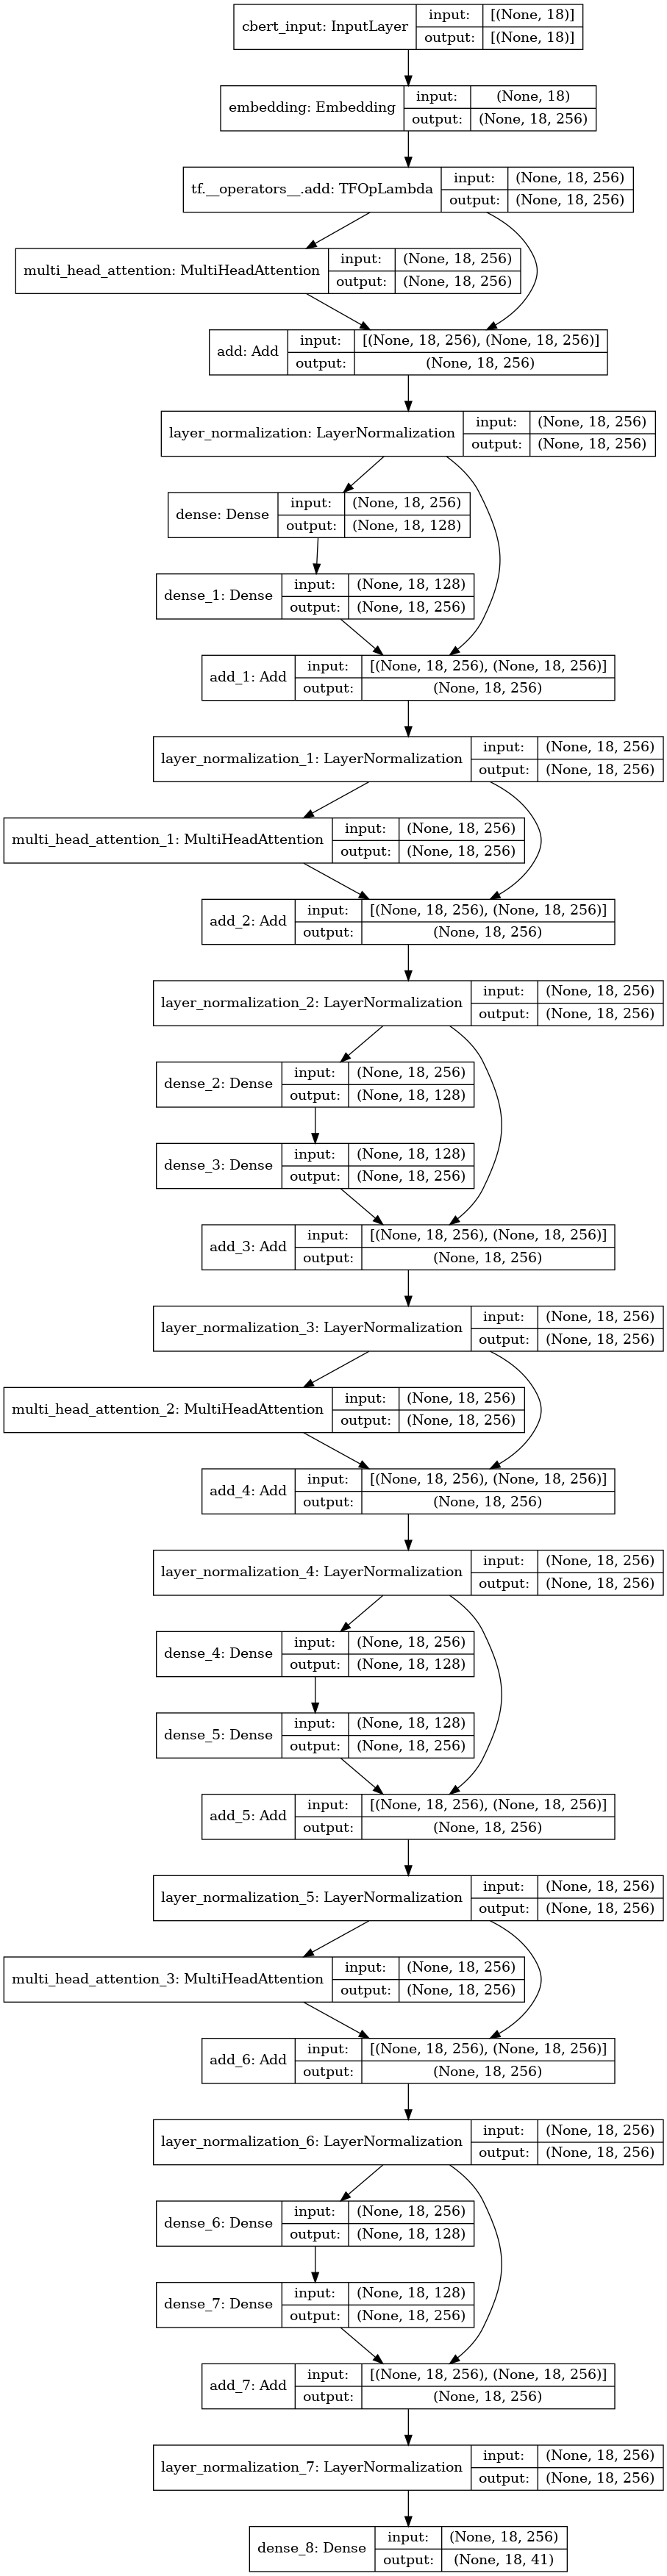

In [17]:
tf.keras.utils.plot_model(cbert, show_layer_names=True, show_shapes=True)

# Training

In [18]:
# 8 heads 4 blocks Adam optimizer

# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = cbert_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy metric to monitor and save the best model weights
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0),
                metrics=tf.keras.metrics.SparseCategoricalAccuracy())

test_loss = model.evaluate(test_ds)
print(f"Perplexity: {math.exp(test_loss[0]):.2f}")

27/27 [==============================] - 4s 15ms/step - loss: 0.5441 - sparse_categorical_accuracy: 0.0120
Perplexity: 1.72


In [19]:
steps_per_epoch = len(train_masked_labels) // config.BATCH_SIZE
validation_steps = len(valid_masked_labels) // config.BATCH_SIZE

tf.keras.backend.clear_session()
with strategy.scope():
  model = cbert_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy metric to monitor and save the best model weights
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0),
                metrics=tf.keras.metrics.SparseCategoricalAccuracy())

ckpt = tf.keras.callbacks.ModelCheckpoint('best_weights.h5',
                                           monitor='val_loss',
                                           verbose=1,
                                           save_best_only=True, 
                                           save_weights_only=True,
                                           mode='min')
model.fit(train_ds, validation_data=valid_ds, epochs=config.EPOCHS,
          steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, callbacks=ckpt)

Epoch 1/100
498/498 [==============================] - 35s 36ms/step - loss: 0.3598 - sparse_categorical_accuracy: 0.0359 - val_loss: 0.3045 - val_sparse_categorical_accuracy: 0.0497

Epoch 00001: val_loss improved from inf to 0.30447, saving model to best_weights.h5
Epoch 2/100
498/498 [==============================] - 15s 30ms/step - loss: 0.3011 - sparse_categorical_accuracy: 0.0508 - val_loss: 0.2937 - val_sparse_categorical_accuracy: 0.0543

Epoch 00002: val_loss improved from 0.30447 to 0.29368, saving model to best_weights.h5
Epoch 3/100
498/498 [==============================] - 15s 30ms/step - loss: 0.2922 - sparse_categorical_accuracy: 0.0548 - val_loss: 0.2888 - val_sparse_categorical_accuracy: 0.0565

Epoch 00003: val_loss improved from 0.29368 to 0.28884, saving model to best_weights.h5
Epoch 4/100
498/498 [==============================] - 15s 30ms/step - loss: 0.2876 - sparse_categorical_accuracy: 0.0569 - val_loss: 0.2856 - val_sparse_categorical_accuracy: 0.0587

Epoc